In [2]:
import torch
import pickle
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [3]:
model_names = [
    'model_51_3_PL.pkl',
    'model_51_4_FL.pkl',
    'model_429_3_FL.pkl',
    'model_52_4_PL.pkl',
]
models = []
for m in model_names:
    with open(m, 'rb') as file:
        cur_model = pickle.load(file)        
        cur_model = cur_model.to(torch.float32)
        models.append(cur_model)

/Users/johnboesen/Documents/Code/#Harvard/220-proj/220-env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# cast_test = []
with open('test_set.pkl', 'rb') as file:
    test_set = pickle.load(file)
    # for i, (g, y) in enumerate(test_set):
    #     cast_test.append((g, y)) # float64
# test_set = cast_test

In [5]:
def test_model(model):
    test_losses = []
    y_preds = []
    simple_loss = nn.MSELoss(reduction='mean')
    for batch_graph, graph_labels in test_set:
        if torch.cuda.is_available():
            batch_graph = batch_graph.to(torch.cuda.current_device())
            graph_labels = graph_labels.cuda()
        model.eval()
        with torch.no_grad():
            batch_graph.ndata['feat'] = batch_graph.ndata['feat'].float()
            ypred = model(batch_graph)
            y_preds.append(ypred)
            loss = simple_loss(ypred, torch.tensor([graph_labels], dtype=torch.float32))
            if loss.item() < 50 or torch.any(ypred > 50): # Throw out outliers
                test_losses.append(loss.item())
    return test_losses, y_preds

In [6]:
losses, preds = [], []
for i in range(4):
    l, p = test_model(models[i])
    losses.append(np.mean(l))
    preds.append(p)

/Users/johnboesen/Documents/Code/#Harvard/220-proj/220-env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([20])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/johnboesen/Documents/Code/#Harvard/220-proj/220-env/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


(array([[1., 0., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 1.],
        ...,
        [1., 0., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 1.],
        [1., 0., 0., ..., 0., 0., 1.]]),
 array([0.99702215, 0.99764097, 0.99825978, 0.99887854, 0.99949735,
        1.00011611, 1.00073493, 1.00135374, 1.00197256, 1.00259137,
        1.00321019]),
 <a list of 232 BarContainer objects>)

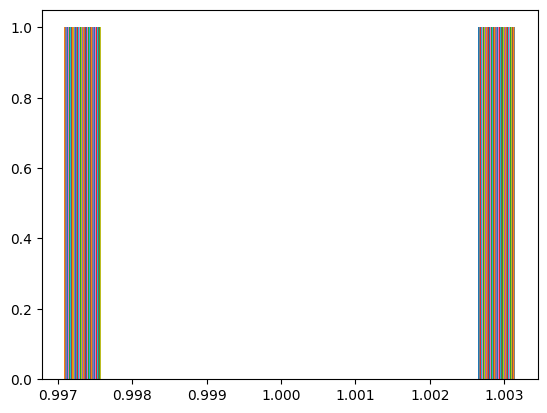

In [7]:
plt.hist(preds[2])

In [8]:
[np.mean(x) for x in losses]

[0.09695915738424367,
 0.09107174038350502,
 0.08946332325209448,
 0.09201357442602191]

## Standard Deviation

In [17]:
[np.array(x).std() for x in preds]

[0.055967025, 0.037011605, 0.0030940175, 0.045427382]

In [27]:
np.array([x[1] for x in test_set if x[1] < 50]).std()

0.5672559838298923